# MIDTERM: PARAMETER ESTIMATION

# Questions

In this homework, you will do a parameter estimation for
BioModels model 957, a model of COVID.

1. (10 pts) **Acquire the Model**. Create a roadrunner instance of the model and print the antimony representation of the model in an output cell.

1. (20 pts) **Data Generation**. Create synthetic data for the floating species using the values of the parameter in the published model:
   1. (10 pts) Create a function ``generateNoisyData``: Creates noisy versions of the simulation floating species. Inputs are antimony model and stadard deviation of noise; outputs are SBstoat.NamedTimeseries.
   1. (5 pts) Create and save in a global variable synthetic data for standard deviations of 0, 0.1, 0.5, 1.0, 2.0.
   1. (5 pts) Plot the three datatsets. What characteristics of the data confirm that these synthetic data
   are consistent with your expectations.
   
1. (40 pts) **Experiment Infrastructure**. Implement the following functions:

    1. (10 pts) ``getParameters``: Creates a list of SBstoat.Parameter from a dictionary with keys of parameter names and values that are the values of parameters in the model. It also has arguments that indicate the range for the parameter (as a fraction of the parameter's true value) and the starting value.
    1. (30 pts) ``doFit``: Encapsulates the fitting and evaluation workflow. Inputs are: antimony model, standard deviation of noise, the fitting method, and fractions of the true value for: lower end of parameter search, starting value of parameter search, and upper end of parameter search; Outputs are: residual sum of squares of the fit and the number of function evaluations (see ``getFitterInfo`` in Helper Functions.

   
1. (30 pts) **Experiments and Analysis**.
Use the experiment infrastructure to determine of effects of: standard deviation of noise,
search range, and search algorithm. You want to understand the impact on accuracy of parameter estimates and the time to do the parameter estimation. We will quantify accuracy in terms of residual sum of square, and time is in units of function evaluations.

    A. (10 pts) Plot the results. All experiments should set the starting value of the search
to the lower end of the range.
        1. Use the data generated in Question 2.
        1. Use the search ranges lower_frc, upper_frc = (0.5, 2.0) and (0.25, 4.0)
        1. Use the search algorithms ``leastsquares`` and ``differential_evolution``
   
   Construct plots as follows:
   
        1. x-axis: standard deviation
        2. y-axis: residual sum of squares, maximum estimation error, median estimation error, number of function evaluations (set getFitterInfo in Helpers)
        3. Do 2 plots; one for each combination of lower_frc, upper_frc
    
   B. (20 pts) Answer the following questions. (5 pts for each correct answer)
       1. Which algorithm (leastsquares or differential_evolution) works best for these data and why?
       1. Why are the maximum error and median error higher for the search range (0.25, 4.0) compared with (0.5, 2.0)?
       1. Why does the residual sum of squares (RSSQ) increase with standard deviation?
       1. Why does do estimation errors (max_err and median_err) increase from standard deviation of 0 to non-zero standard deviations?

**Please do your homework in a copy of this notebook, maintaining the sections.**

**Don't forget to document your functions and include tests. All tests must have at least one ``assert``**

# Programming Preliminaries
This section provides the setup to run your python codes.

## Imports

In [1]:
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import SBstoat
import tellurium as te

## Constants

In [2]:
STDS = [0, 0.1, 0.5, 1.0, 2.0]
# Key and column names
STD = "std"
RSSQ = "rssq"
NUM_EVAL = "num_eval"
METHOD = "method"
MAX_ERR = "max_err"
MEDIAN_ERR = "median_err"
REPL = "repl"
TS = "timeseries"

# Helper Functions

In [3]:
TEST_MODEL = """
A->B; A
B->; k*B; 
A = 10; 
B=0
k = 2
"""
TEST_MODEL_RR = te.loada(TEST_MODEL)
TEST_MODEL_ARR = TEST_MODEL_RR.simulate()
TEST_MODEL_TS = SBstoat.NamedTimeseries(array=TEST_MODEL_ARR, colnames=TEST_MODEL_ARR.colnames)

In [4]:
def arrToDF(arr):
    """
    Converts a NamedArray into a DataFrame.
    If it is simulation output, makes TIME the index.

    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    DataFrame
        Removes "[" , "]" from the names of species
    """
    columns = [c[1:-1] if c[0] == "[" else c for c in arr.colnames]
    df = pd.DataFrame(arr, columns=columns)
    df = df.set_index("time")
    return df

# Tests
assert(isinstance(arrToDF(TEST_MODEL_ARR), pd.DataFrame))
print("OK!")

OK!


In [5]:
def arrToTS(arr):
    """
    Converts NamedArray to a NamedTimeseries
    
    Parameters
    ----------
    arr: NamedArray
    
    Returns
    -------
    NamedTimeseries
    """
    return SBstoat.NamedTimeseries(array=arr, colnames=arr.colnames)

# Tests
assert(isinstance(arrToTS(TEST_MODEL_ARR), SBstoat.NamedTimeseries))
print("OK!")

OK!


In [6]:
def getParameterValueDct(model):
    """
    Finds the name and value of all parameters.
    
    Parameters
    ----------
    model: str (Antimony model)
    
    Returns
    -------
    dict (key: str, value: float)
    """
    rr = te.loada(model)
    return {n: rr[n] for n in rr.model.getGlobalParameterIds()}

# Tests
dct = getParameterValueDct(TEST_MODEL)
assert(isinstance(dct, dict))
assert("k" in dct.keys())
print("OK!")

OK!


In [7]:
FitterInfo = collections.namedtuple("FitterInfo", "rssq num_eval fitter max_err median_err")

def getFitterInfo(fitter):
    """
    Calculates statistics for the accuracy of a fit.
    
    Parameters
    ----------
    fitter: SBstoat.ModelFitter
    
    Returns
    -------
    FitterInfo
    """
    df = (fitter.residualsTS.to_dataframe()**2)
    rssq = df.sum().sum()
    # Find the number of function evaluations
    report_stg = fitter.reportFit()
    pos = report_stg.index("function evals")
    stg = report_stg[pos:]
    start_pos = stg.index("=") + 1
    end_pos = stg.index("\n")
    num_eval = int(stg[start_pos:end_pos])
    # Get statistics on the fit
    fitter.roadrunnerModel.resetAll()
    parameter_value_dct = getParameterValueDct(fitter.roadrunnerModel.getAntimony())
    errs = []
    for key, value in fitter.params.valuesdict().items():
        err = np.abs(value - parameter_value_dct[key])/parameter_value_dct[key]
        errs.append(err)
    max_err = max(errs)
    median_err = np.median(errs)
    #
    return FitterInfo(rssq=rssq, num_eval=num_eval, fitter=fitter, max_err=max_err, median_err=median_err)
    

# Tests
fitter = SBstoat.ModelFitter(TEST_MODEL, TEST_MODEL_TS, parametersToFit=[SBstoat.Parameter("k", lower=1, value=1, upper=4)])
fitter.fitModel()
fitter_info = getFitterInfo(fitter)
assert(np.isclose(fitter_info.rssq, 0))
assert(fitter_info.num_eval < 10)
print("OK!")

OK!


# Question 1: Acquire the model

In [8]:
MODEL_RR = te.loadSBMLModel("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000957.6?filename=Roda2020.xml")
MODEL_ARR = MODEL_RR.simulate()
MODEL_ANT = MODEL_RR.getAntimony()
print(MODEL_ANT)

// Created by libAntimony v2.13.2
function Rate_Law_for_Susceptible_to_Infected(beta, I, S)
  beta*I*S;
end

Rate_Law_for_Susceptible_to_Infected is "Rate Law for Susceptible_to_Infected"


model *Roda2020___SIR_model_of_COVID_19_spread_in_Wuhan()

  // Compartments and Species:
  compartment Wuhan;
  species Susceptible in Wuhan, Infected in Wuhan, Recovered in Wuhan, Confirmed in Wuhan;

  // Reactions:
  Susceptible_to_Infected: Susceptible => Infected; Wuhan*Rate_Law_for_Susceptible_to_Infected(beta, Infected, Susceptible);
  Infected_to_Recovered: Infected => Recovered; Wuhan*mu*Infected;
  Infected_to_Confirmed: Infected => Confirmed; Wuhan*rho*Infected;

  // Species initializations:
  Susceptible = 5999755;
  Infected = 60;
  Recovered = 0;
  Confirmed = 0;

  // Compartment initializations:
  Wuhan = 1;

  // Variable initializations:
  beta = 2.09e-07;
  rho = 0.909;
  mu = 0.1;

  // Other declarations:
  const Wuhan, beta, rho, mu;

  // Unit definitions:
  unit length = me

In [9]:
PARAMETER_DCT = getParameterValueDct(MODEL_ANT)
len(PARAMETER_DCT)

3

# Question 2: Data Generation

In [10]:
def generateNoisyData(std, model=MODEL_ANT, is_plot=True):
    """
    Generates noise columns in a dataframe.
    
    Parameters
    ----------
    std: float (standard deviation of generated noise)
    model: str (antimony model)
    is_plot: bool (plot the noise)
    
    Returns
    -------
    NamedTimeseries
    """
    rr = te.loada(model)
    data = rr.simulate()
    df = arrToDF(data)
    normalization_ser = df.mean()
    # Use the input DataFrame as a template
    noise_df = df.copy()
    # Create the noise data
    for column in noise_df.columns:
        noise_arr = np.random.normal(0, std, len(noise_df))
        noise_df[column] = normalization_ser.loc[column]*noise_arr
    data_df = df + noise_df
    if is_plot:
        _, ax = plt.subplots(1)
        for column in data_df.columns:
            ax.scatter(data_df.index, data_df[column])
        plt.legend(noise_df.columns)
        plt.title("Generated Noise. Std=%2.2f" % std)
    return SBstoat.NamedTimeseries(dataframe=data_df)
                  
# Tests
df = generateNoisyData(0, is_plot=False)
assert(isinstance(df, SBstoat.NamedTimeseries))
print("OK!")

OK!


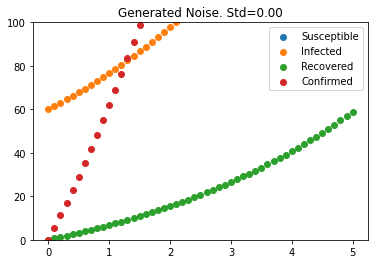

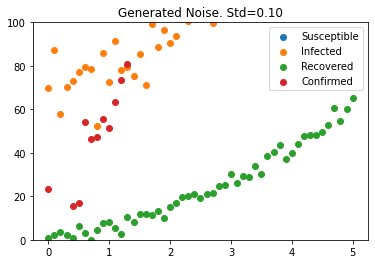

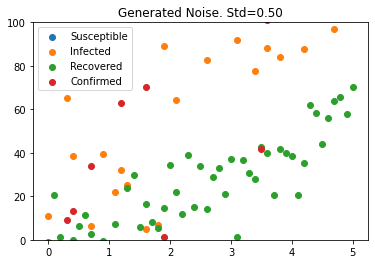

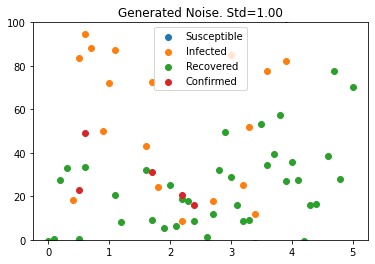

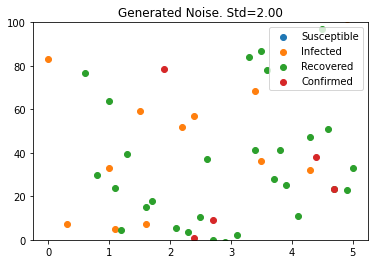

In [11]:
DATA_DCT = {STD: [], TS: []}
for std in STDS:
    DATA_DCT[STD].append(std)
    DATA_DCT[TS].append(generateNoisyData(std))
    plt.ylim([0, 100])

# Question 3: Experiment Infrastructure

In [12]:
# Dictionary representation of the parameters and their values
def getParameters(parameter_value_dct, lower_frc=1.0, value_frc=1.0, upper_frc=1.0):
    """
    Constructs the list of parameters for for the model.
    
    Parameters
    ----------
    parameter_value_dct: dict (key: name, value: parameter value)
    lower_frc: float (fraction used to calculate lower range of search. Should be in [0, 1.0])
    value_frc: float (fraction used to calculate start of search. lower_frc <= value_frc <= upper_frc)
    upper_frc: float (fraction used to calculate upper limit of search. Should be in [value_frc, inf])
    
    Returns
    -------
    list-SBstoat.Parameter
    """
    parameters = []
    for key, true_value in parameter_value_dct.items():
        lower = lower_frc*true_value
        value = value_frc*true_value
        upper = upper_frc*true_value
        parameter = SBstoat.Parameter(key, lower=lower, value=value, upper=upper)
        parameters.append(parameter)
        # Calculate median
    return parameters

# Tests
parameter_value_dct = {"k1": 1, "k2": 2}
parameters = getParameters(parameter_value_dct, lower_frc=0.5, value_frc=0.8, upper_frc=2.0)
assert(len(parameters) == 2)
assert(isinstance(parameters[0], SBstoat.Parameter))
assert(parameters[0].lower == 0.5)
assert(parameters[0].value == 0.8)
assert(parameters[0].upper == 2.0)
print("OK!")

OK!


In [13]:
def doFit(observed_ts, model=MODEL_ANT,
          fitter_methods=["leastsq"], 
          lower_frc=0.5,
          value_frc=0.5,
          upper_frc=2.0,
          is_report=False):
    """
    Encapsulates the workflow to fit the linear pathway model and return appropirate statistics.

    Parameters
    ----------
    model: str (Antimony model)
    observed_ts: NamedTimeseries (synthetic data)
    fitter_method: str ("leastsquares" or "differential_evolution")
    lower_frc, value_frc, upper_frc: scaling of range for parameters
    is_report: bool
        Produce outputs

    Returns
    -------
    FitterInfo
    """
    parameter_value_dct = getParameterValueDct(model)
    parameters = getParameters(parameter_value_dct, lower_frc=lower_frc, value_frc=value_frc, upper_frc=upper_frc)
    # Construct the fitter and do the fit
    fitter = SBstoat.ModelFitter(model, observed_ts,
                         fitterMethods=fitter_methods, 
                         parametersToFit=parameters)
    fitter.fitModel()
    if is_report:
        print(fitter.reportFit())
        fitter.plotFitAll(figsize=(20, 5), numCol=5, color=["red", "blue"],
                          titlePosition=(0.5, 1.05))
    return getFitterInfo(fitter)

# TESTS
fitter_info = doFit(DATA_DCT[TS][0], fitter_methods=["leastsquares"],
              lower_frc=0.5, value_frc=0.5, upper_frc=2.0, is_report=False)
assert(fitter_info.rssq > 0)
assert(fitter_info.num_eval > 0)
print("OK")

OK


# Question 4: Experiment Execution and Analysis

In [14]:
def makePlot(model=MODEL_ANT, search_range=2, data_dct=DATA_DCT, is_plot=True):
    """
    Creates a results plot for the specified parameters.
    
    Parameters
    ----------
    model: str (antimony model)
    search_range: float (size of the search range for the fit)
    data_dct: dict (keys: STD (standard deviation), TS (timeseries))
    
    Returns
    -------
    DataFrame: columns
        std: standard deviation of data
        rssq: residual sum of squares of fit
        num_eval: number of evaluations
        method: optimization algorithm
        max_err: maximum fitting error for the parameters
        median_err: median fitting error
    """
    # Initializations
    lower_frc = 1/search_range
    value_frc = lower_frc
    upper_frc = search_range
    METHODS =  ["leastsquares", "differential_evolution"]
    # Obtain the fitter results
    result_dct = {n: [] for n in [STD, RSSQ, NUM_EVAL, METHOD, MAX_ERR, MEDIAN_ERR]}
    for method in METHODS:
        for std, ts in zip(data_dct[STD], data_dct[TS]):
            fitter_info = doFit(ts, model=model, fitter_methods=[method], lower_frc=lower_frc,
                  value_frc=value_frc, upper_frc=upper_frc, is_report=False)
            result_dct[STD].append(std)
            result_dct[METHOD].append(method)
            result_dct[RSSQ].append(fitter_info.rssq)
            result_dct[NUM_EVAL].append(fitter_info.num_eval)
            result_dct[MAX_ERR].append(fitter_info.max_err)
            result_dct[MEDIAN_ERR].append(fitter_info.median_err)
    result_df = pd.DataFrame(result_dct)
    # Construct plot
    if is_plot:
        fig, axes = plt.subplots(1, 4, figsize=(15, 5))
        fig.tight_layout(pad=5.0)
        colors = ["red", "blue"]
        for idx, method in enumerate(METHODS):
            plot_df = result_df[result_df[METHOD] == method]
            axes[0].plot(plot_df[STD], plot_df[NUM_EVAL], color=colors[idx], marker="o")
            axes[1].plot(plot_df[STD], plot_df[MAX_ERR], color=colors[idx], marker="o")
            axes[2].plot(plot_df[STD], plot_df[MEDIAN_ERR], color=colors[idx], marker="o")
            axes[3].plot(plot_df[STD], plot_df[RSSQ], color=colors[idx], marker="o")
        #
        axes[0].set_ylabel("num evaluations")
        axes[1].set_ylabel("max error")
        axes[2].set_ylabel("median error")
        axes[3].set_ylabel("rssq")
        axes[0].legend(METHODS, loc="upper right")
        for ax in axes:
            ax.set_xlabel("noise std")
    return result_df

# Tests
stds = [0, 1, 1.5, 2, 2.5, 3]
data_dct = {STD: [], TS: []}
for std in stds:
    data_dct[STD].append(std)
    data_dct[TS].append(generateNoisyData(std, model=TEST_MODEL, is_plot=False))
result_df = makePlot(model=TEST_MODEL, search_range=2, data_dct=data_dct, is_plot=False)
diff = set(result_df.columns).symmetric_difference([STD, RSSQ, NUM_EVAL, METHOD, MAX_ERR, MEDIAN_ERR])
assert(len(diff) == 0)
print("OK!")

OK!


Analysis of the model

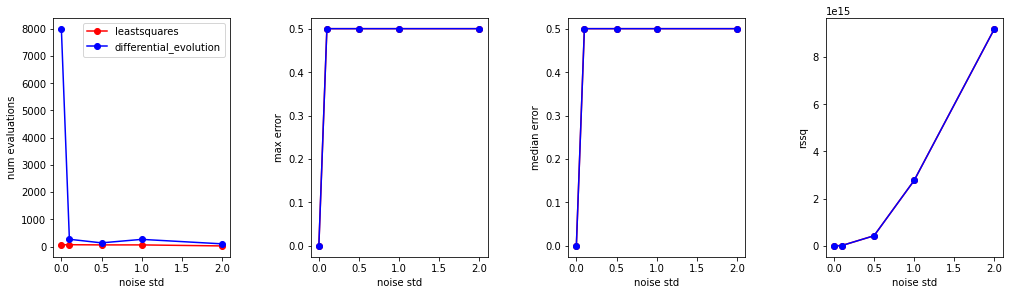

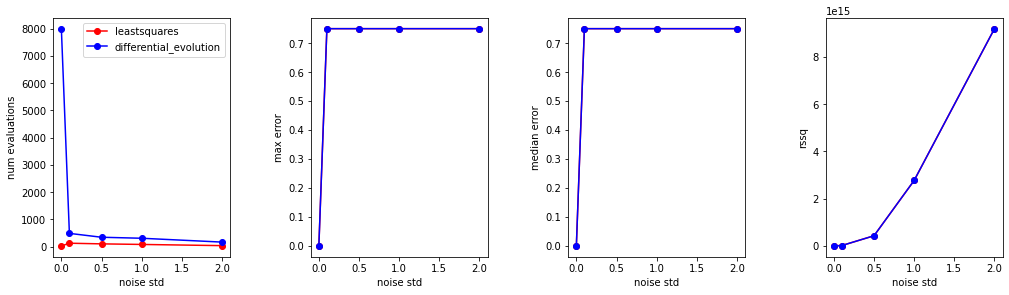

In [15]:
result_df = makePlot(model=MODEL_ANT, search_range=2, data_dct=DATA_DCT, is_plot=True)
result_df = makePlot(model=MODEL_ANT, search_range=4, data_dct=DATA_DCT, is_plot=True)

**Questions and Answers**
1. Which algorithm (leastsquares or differential_evolution) works best for these data and why?
    1. leastsquares seems better since it has a much lower number of function evaluations and the same parameter estimation errors.
1. Why are the estimation errors (maximum error and median error) higher for the search range (0.25, 4.0) compared with (0.5, 2.0)?
    1. The wider range means that parameter estimates can be further from the true value, and so larger errors are possible.
    1. Also, the wider range creates a larger search space, and so algorithms may not perform as well.
1. Why does the residual sum of squares (RSSQ) increase with standard deviation?
    1. This is a result of having larger variability in the data and so there is a larger variance (and hence residual sum of squares)
for the parameter estimates.
1. Why does do estimation errors (max_err and median_err) increase from standard deviation of 0 to non-zero standard deviations?
    1. It's more difficult to fit noisy data.